# Setup



## Get files / dependencies

In [ ]:
%tensorflow_version 1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
!python --version

Python 3.7.11


In [ ]:
!git clone https://github.com/google-research/proteinfer 

%cd proteinfer

!pip3 install -qr  requirements.txt

import pandas as pd
import tensorflow
import inference
import parenthood_lib
import baseline_utils,subprocess
import shlex
import tqdm 
import sklearn
import numpy as np
import utils
import colab_evaluation
import plotly.express as px

from plotnine import ggplot, geom_point, geom_point, geom_line, aes, stat_smooth, facet_wrap, xlim,coord_cartesian,theme_bw,labs,ggsave


Cloning into 'proteinfer'...
remote: Enumerating objects: 473, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 473 (delta 91), reused 49 (delta 20), pack-reused 277
Receiving objects: 100% (473/473), 9.11 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (230/230), done.
/content/proteinfer
     |████████████████████████████████| 99 kB 3.6 MB/s 
     |████████████████████████████████| 2.3 MB 14.2 MB/s 
     |████████████████████████████████| 10.8 MB 18.5 MB/s 
     |████████████████████████████████| 2.8 MB 52.7 MB/s 
     |████████████████████████████████| 59 kB 4.9 MB/s 
     |████████████████████████████████| 89 kB 5.7 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 17.3 MB 23.0 MB/s 
     |████████████████████████████████| 10.5 MB 50.1 MB/s 
     |████████████████████████████████| 107 kB 70.6 MB/s 
     |████████████████████████████████| 13.1 MB 40.4 MB/s 
     

In [ ]:
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/models/zipped_models/noxpd2_cnn_swissprot_go_random_swiss-cnn_for_swissprot_go_random-13731645.tar.gz
!tar xzf noxpd2_cnn_swissprot_go_random_swiss-cnn_for_swissprot_go_random-13731645.tar.gz
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/colab_support/parenthood.json.gz
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/fasta_files/SWISSPROT_RANDOM_GO/eval_test.fasta

## Load vocabulary and parenthood information

In [ ]:
vocab = inference.Inferrer(
    'noxpd2_cnn_swissprot_go_random_swiss-cnn_for_swissprot_go_random-13731645'
).get_variable('label_vocab:0').astype(str)
label_normalizer = parenthood_lib.get_applicable_label_dict(
    'parenthood.json.gz')

W0908 10:41:05.693955 139873039775616 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/ragged/ragged_tensor.py:1586: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Define a helper function to download inference results

In [ ]:
def download_inference_results(run_name):
    file_shard_names = [
        '-{:05d}-of-00064.predictions.gz'.format(i) for i in range(64)
    ]
    subprocess.check_output(
        shlex.split(f'mkdir -p ./inference_results/{run_name}/'))

    for shard_name in tqdm.tqdm(file_shard_names,
                                position=0,
                                desc="Downloading"):
        subprocess.check_output(
            shlex.split(
                f'wget https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/swissprot_inference_results/{run_name}/{shard_name} -O ./inference_results/{run_name}/{shard_name}'
            ))
    return


# Downloading the data and getting it ready for analysis

In [ ]:
min_decision_threshold = 1e-3

download_inference_results(f"go_random_test")

predictions_df = colab_evaluation.get_normalized_inference_results(
    "inference_results/go_random_test",
    vocab,
    label_normalizer,
    min_decision_threshold=min_decision_threshold)


100%|██████████| 64/64 [15:08<00:00, 14.38s/it]


In [ ]:
test_ground_truth = baseline_utils.load_ground_truth('eval_test.fasta')
ground_truth_df = colab_evaluation.make_tidy_df_from_ground_truth(
    test_ground_truth)
del test_ground_truth

108578it [00:01, 63382.08it/s]
100%|██████████| 54289/54289 [00:01<00:00, 37184.31it/s]


# Analysis


In [ ]:
cnn_pr_data = colab_evaluation.get_pr_curve_df(predictions_df, ground_truth_df)


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


In [ ]:
cnn_pr_data.drop(index=0)

,group,precision,recall,threshold,f1
1,all,0.710492,0.917949,0.001000,0.801006
2,all,0.711266,0.917845,0.001014,0.801458
3,all,0.712026,0.917743,0.001030,0.801901
4,all,0.712716,0.917642,0.001045,0.802300
5,all,0.713583,0.917541,0.001063,0.802810
...,...,...,...,...,...
1914,all,0.988057,0.684312,1.000000,0.808600
1915,all,0.988178,0.682954,1.000000,0.807692
1916,all,0.988711,0.677492,1.000000,0.804036
1917,all,0.988837,0.675964,1.000000,0.803001


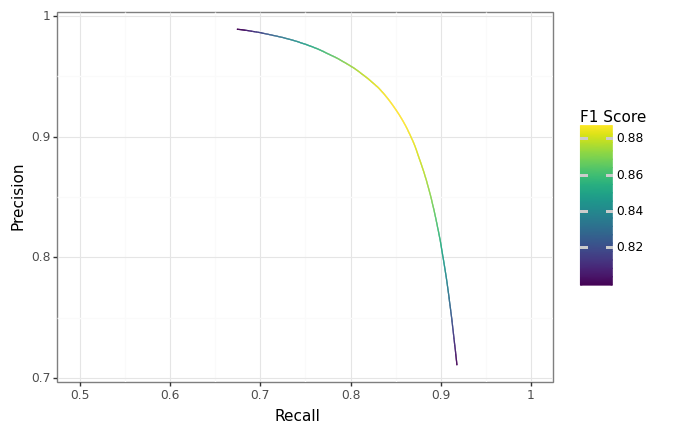

<ggplot: (8741814874517)>

In [ ]:
ggplot(cnn_pr_data.drop(index=0),
       aes(x="recall", y="precision",
           color="f1")) + geom_line() + geom_line() + coord_cartesian(
               xlim=(0.5, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="F1 Score")


What decision threshold maximises F1 score?

In [ ]:
cnn_pr_data.sort_values('f1', ascending=False)[:3]


,group,precision,recall,threshold,f1
633,all,0.918018,0.854018,0.710102,0.884862
632,all,0.917888,0.854119,0.707867,0.884856
635,all,0.918238,0.853815,0.713999,0.884856


Now let's have a look at PR curves for each different top level group.

# Load CNN ensemble predictions

In [ ]:
min_decision_threshold = 1e-3
download_inference_results(f"go_random_test_ens")
ens_predictions_df = colab_evaluation.get_normalized_inference_results(
    "inference_results/go_random_test_ens",
    vocab,
    label_normalizer,
    min_decision_threshold=min_decision_threshold)


100%|██████████| 64/64 [15:39<00:00, 15.16s/it]


In [ ]:
ens_cnn_pr_data = colab_evaluation.get_pr_curve_df(ens_predictions_df,
                                                   ground_truth_df)


100%|██████████| 1/1 [00:13<00:00, 13.92s/it]


In [ ]:
ens_cnn_pr_data.sort_values('f1', ascending=False)[0:3]


,group,precision,recall,threshold,f1
863,all,0.919477,0.880319,0.376871,0.899472
876,all,0.920896,0.879012,0.387133,0.899466
862,all,0.919356,0.880419,0.375979,0.899466


In [ ]:
cnn_pr_data['method'] = "CNN"
ens_cnn_pr_data['method'] = "CNN Ensemble"

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



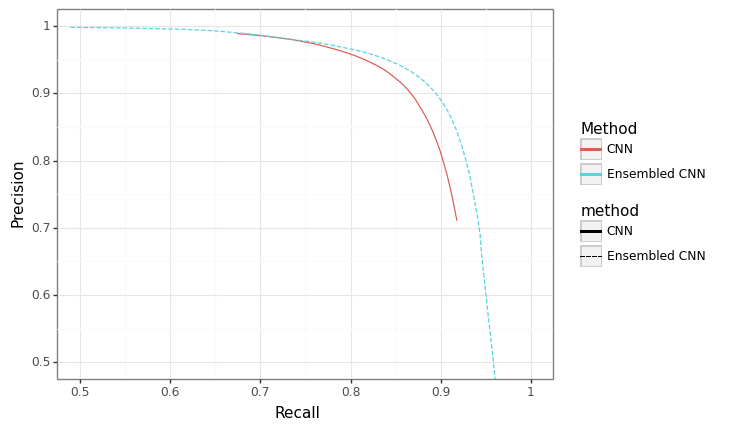

<ggplot: (8741627518749)>

In [ ]:
method_comparison = pd.concat([cnn_pr_data, ens_cnn_pr_data],
                              ignore_index=True)
ggplot(method_comparison.query("recall<1"),
       aes(x="recall", y="precision", color="method",
           linetype="method")) + geom_line() + coord_cartesian(
               xlim=(0.5, 1), ylim=(0.5, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method")


# Blast comparison

Let's do the same sort of analysis for a BLAST baseline.

In [ ]:
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/blast_output/random/blast_out_test.tsv
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/fasta_files/SWISSPROT_RANDOM_GO/eval_test.fasta
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/fasta_files/SWISSPROT_RANDOM_GO/train.fasta
train_ground_truth = colab_evaluation.make_tidy_df_from_ground_truth(baseline_utils.load_ground_truth('train.fasta')).rename(columns={"up_id":"train_seq_id"}).drop(columns=["gt"])

877044it [00:14, 58510.66it/s]
100%|██████████| 438522/438522 [00:11<00:00, 39569.33it/s]


In [ ]:
blast_out = colab_evaluation.read_blast_table("blast_out_test.tsv")
blast_df = blast_out.merge(train_ground_truth,
                           left_on="target",
                           right_on="train_seq_id")
blast_df.rename(columns={'bit_score': 'value', "query": "up_id"}, inplace=True)


In [ ]:
min_decision_threshold = 0
blast_pr_data = colab_evaluation.get_pr_curve_df(blast_df, ground_truth_df)
blast_pr_data['method'] = 'BLAST'

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



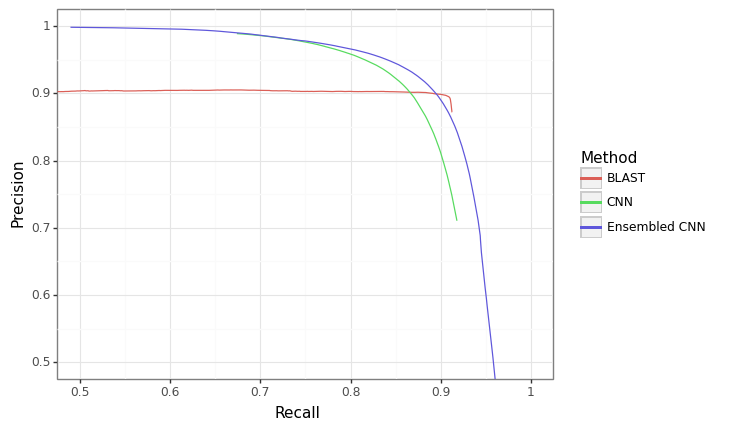

<ggplot: (8741694436997)>

In [ ]:
cnn_pr_data['method'] = 'CNN'
ens_cnn_pr_data['method'] = 'Ensembled CNN'
method_comparison = pd.concat([
    cnn_pr_data.drop(index=0),
    ens_cnn_pr_data.drop(index=0),
    blast_pr_data.drop(index=0)
],
                              ignore_index=True)
ggplot(method_comparison,
       aes(x="recall", y="precision",
           color="method")) + geom_line() + coord_cartesian(
               xlim=(0.5, 1), ylim=(0.5, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method")


In [ ]:
method_comparison.groupby("method")[['f1']].agg(max)

,f1
method,
BLAST,0.902019
CNN,0.884862
Ensembled CNN,0.899472


In [ ]:
method_comparison.sort_values('f1',
                              ascending=False).drop_duplicates(['method'])


,group,precision,recall,threshold,f1,method
5590,all,0.895459,0.908676,46.600000,0.902019,BLAST
2780,all,0.919477,0.880319,0.376871,0.899472,Ensembled CNN
632,all,0.918018,0.854018,0.710102,0.884862,CNN


Let's investigate what's going on at the left hand side of the graph where the CNN and ensemble achieve greater precision than BLAST.

In [ ]:
def get_x_where_y_is_closest_to_z(df, x, y, z):
    return df.iloc[(df[y] - z).abs().argsort()[:1]][x]


cnn_threshold = float(
    get_x_where_y_is_closest_to_z(cnn_pr_data,
                                  x="threshold",
                                  y="recall",
                                  z=0.96))
blast_threshold = float(
    get_x_where_y_is_closest_to_z(blast_pr_data,
                                  x="threshold",
                                  y="recall",
                                  z=0.96))

cnn_results = colab_evaluation.assign_tp_fp_fn(ens_predictions_df,
                                               ground_truth_df, cnn_threshold)

blast_results = colab_evaluation.assign_tp_fp_fn(blast_df, ground_truth_df,
                                                 blast_threshold)

merged = cnn_results.merge(blast_results,
                           how="outer",
                           suffixes=("_ens_cnn", "_blast"),
                           left_on=["label", "up_id", "gt"],
                           right_on=["label", "up_id", "gt"])


In [ ]:
blast_info = blast_out[['up_id', 'target', 'pc_identity']]


Let's list some of the BLAST false-positives in case we want to investigate what's going on.

In [ ]:
merged.query("fp_blast==True and fp_ens_cnn==False").head()

,up_id,label,value_ens_cnn,gt,tp_ens_cnn,fp_ens_cnn,fn_ens_cnn,target,pc_identity,alignment_length,value_blast,train_seq_id,tp_blast,fp_blast,fn_blast


# An ensemble of BLAST and ensembled-CNNs

We've seen that the CNN-ensemble and BLAST have different strengths - at lower recalls the CNN appears to have greater precision than BLAST at lower recalls, but BLAST has better recall at lower precisions. Can we combine these approaches to get a predictor with the best of both worlds?

In [ ]:
blast_and_cnn_ensemble = ens_predictions_df.merge(blast_df,
                                                  how="outer",
                                                  suffixes=("_ens_cnn",
                                                            "_blast"),
                                                  left_on=["label", "up_id"],
                                                  right_on=["label", "up_id"])


In [ ]:
blast_and_cnn_ensemble = blast_and_cnn_ensemble.fillna(False)


We will create a simple ensemble where the value of the predictor is simply the multiple of the probability assigned by the ensemble of neural networks and the bit-score linking this sequence to to an example with this label by BLAST.

In [ ]:
blast_and_cnn_ensemble['value'] = blast_and_cnn_ensemble[
    'value_ens_cnn'] * blast_and_cnn_ensemble['value_blast']


In [ ]:
blast_and_cnn_ensemble_pr = colab_evaluation.get_pr_curve_df(
    blast_and_cnn_ensemble, ground_truth_df)

100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


In [ ]:
blast_and_cnn_ensemble_pr['method'] = 'Ensemble of BLAST  with  Ensembled-CNN'


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



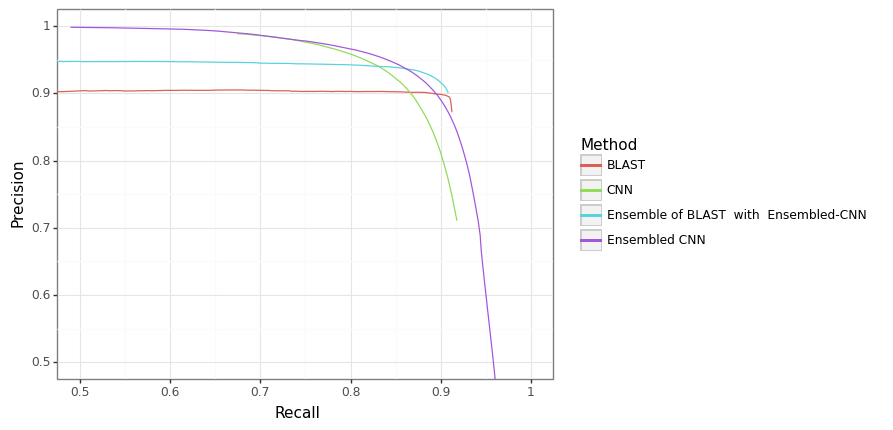

<ggplot: (8741622344077)>

In [ ]:
cnn_pr_data['method'] = 'CNN'
ens_cnn_pr_data['method'] = 'Ensembled CNN'
method_comparison = pd.concat([
    cnn_pr_data.drop(index=0),
    ens_cnn_pr_data.drop(index=0),
    blast_pr_data.drop(index=0),
    blast_and_cnn_ensemble_pr.drop(index=0)
],
                              ignore_index=True)
ggplot(method_comparison,
       aes(x="recall", y="precision",
           color="method")) + geom_line() + coord_cartesian(
               xlim=(0.5, 1), ylim=(0.5, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method")


In [ ]:
method_comparison = method_comparison.query("recall!=1.0")
fig = px.line(method_comparison, x="recall", y="precision", color="method")
fig.update_layout(template="plotly_white", title="Precision-recall by method")
fig.update_xaxes(range=(0.5, 1))
fig.update_yaxes(range=(0.5, 1))
fig.show()
json = fig.to_json(pretty=True)
with open("method.json", "w") as f:
    f.write(json)


In [ ]:
method_comparison.groupby("method")[['f1']].agg(max)

,f1
method,
BLAST,0.902019
CNN,0.884862
Ensemble of BLAST with Ensembled-CNN,0.908158
Ensembled CNN,0.899472


As we hoped, this method seems to provide the best of both worlds, boosting recall compared to the ensembled CNN alone and boosting recall compared to BLAST alone, for a better F1.

# Bootstrapping

In [ ]:
import collections

THRESHOLD = 1e-3


def get_bootstrapped_pr_curves(predictions_df,
                               ground_truth_df,
                               grouping=None,
                               n=100,
                               method_label=None,
                               sample_with_replacement=True):

    joined = predictions_df[predictions_df.value > THRESHOLD].merge(
        ground_truth_df, on=['up_id', 'label'], how='outer')
    print(joined.shape)
    #joined.loc[joined['value'].isna(),'value']=0
    #joined.loc[joined['gt'].isna(),'gt']=False
    unique_up_ids = joined['up_id'].unique()

    pr_samples = []
    for _ in tqdm.tqdm(range(n)):
        sampled_up_ids = np.random.choice(unique_up_ids, len(unique_up_ids),
                                          sample_with_replacement)

        count_by_sample = collections.Counter(sampled_up_ids)
        count_by_sample_ordered = [count_by_sample[x] for x in joined.up_id]
        print(len(sampled_up_ids), len(unique_up_ids),
              sum(count_by_sample.values()), "ee")

        joined_sampled = pd.DataFrame(np.repeat(joined.values,
                                                count_by_sample_ordered,
                                                axis=0),
                                      columns=joined.columns)
        print(joined_sampled.shape, joined.shape, "cc")
        unique_suffixes_counter = collections.defaultdict(lambda: 0)
        unique_suffixes = []
        for row in joined_sampled.values:
            lookup_key = (row[0], row[1])
            unique_suffixes.append(unique_suffixes_counter[lookup_key])
            unique_suffixes_counter[lookup_key] += 1

        joined_sampled['up_id'] = [
            f'{x}-{y}' for x, y in zip(joined_sampled.up_id, unique_suffixes)
        ]

        pred = joined_sampled[joined_sampled['value'].notna()][[
            'up_id', 'label', 'value'
        ]]
        #return joined_sampled
        gt = joined_sampled[joined_sampled['gt'].notna()][[
            'up_id', 'label', 'gt'
        ]]
        print(pred.shape)

        pr_curves = colab_evaluation.get_pr_curve_df(pred,
                                                     gt,
                                                     grouping=grouping)
        pr_curves.loc[pr_curves['threshold'] == 0.0, 'precision'] = 0
        pr_curves['type'] = method_label
        pr_samples.append(pr_curves)
    return pr_samples


In [ ]:
n = 100
non_ensembled_prs = get_bootstrapped_pr_curves(predictions_df,
                                               ground_truth_df,
                                               n=n,
                                               method_label="CNN")
ensembled_prs = get_bootstrapped_pr_curves(ens_predictions_df,
                                           ground_truth_df,
                                           n=n,
                                           method_label="Ensemble")
blast_prs = get_bootstrapped_pr_curves(blast_df,
                                       ground_truth_df,
                                       n=n,
                                       method_label="Blast")
blast_and_cnn_ensemble_prs = get_bootstrapped_pr_curves(
    blast_and_cnn_ensemble,
    ground_truth_df,
    n=n,
    method_label="Blast/CNN-ensemble")


  0%|          | 0/100 [00:00<?, ?it/s]

(3408762, 4)
53463 53463 53463 ee
(3380141, 4) (3408762, 4) cc
(3184444, 3)


  1%|          | 1/100 [00:16<27:37, 16.74s/it]

53463 53463 53463 ee
(3404676, 4) (3408762, 4) cc
(3203498, 3)


  2%|▏         | 2/100 [00:33<27:20, 16.74s/it]

53463 53463 53463 ee
(3408142, 4) (3408762, 4) cc
(3203572, 3)


  3%|▎         | 3/100 [00:50<27:03, 16.74s/it]

53463 53463 53463 ee
(3401447, 4) (3408762, 4) cc
(3199101, 3)


  4%|▍         | 4/100 [01:06<26:45, 16.73s/it]

53463 53463 53463 ee
(3427437, 4) (3408762, 4) cc
(3224186, 3)


  5%|▌         | 5/100 [01:24<26:40, 16.85s/it]

53463 53463 53463 ee
(3409742, 4) (3408762, 4) cc
(3205232, 3)


  6%|▌         | 6/100 [01:41<26:30, 16.92s/it]

53463 53463 53463 ee
(3427369, 4) (3408762, 4) cc
(3221296, 3)


  7%|▋         | 7/100 [01:58<26:24, 17.04s/it]

53463 53463 53463 ee
(3423608, 4) (3408762, 4) cc
(3223052, 3)


  8%|▊         | 8/100 [02:15<26:10, 17.07s/it]

53463 53463 53463 ee
(3385451, 4) (3408762, 4) cc
(3187775, 3)


  9%|▉         | 9/100 [02:32<25:49, 17.03s/it]

53463 53463 53463 ee
(3403049, 4) (3408762, 4) cc
(3203287, 3)


 10%|█         | 10/100 [02:49<25:44, 17.16s/it]

53463 53463 53463 ee
(3446963, 4) (3408762, 4) cc
(3244460, 3)


 11%|█         | 11/100 [03:07<25:33, 17.23s/it]

53463 53463 53463 ee
(3426944, 4) (3408762, 4) cc
(3218038, 3)


 12%|█▏        | 12/100 [03:24<25:22, 17.30s/it]

53463 53463 53463 ee
(3408666, 4) (3408762, 4) cc
(3206768, 3)


 13%|█▎        | 13/100 [03:42<25:07, 17.32s/it]

53463 53463 53463 ee
(3417552, 4) (3408762, 4) cc
(3216785, 3)


 14%|█▍        | 14/100 [03:59<24:55, 17.39s/it]

53463 53463 53463 ee
(3412813, 4) (3408762, 4) cc
(3205249, 3)


 15%|█▌        | 15/100 [04:17<24:38, 17.39s/it]

53463 53463 53463 ee
(3408806, 4) (3408762, 4) cc
(3208521, 3)


 16%|█▌        | 16/100 [04:34<24:28, 17.48s/it]

53463 53463 53463 ee
(3392522, 4) (3408762, 4) cc
(3185752, 3)


 17%|█▋        | 17/100 [04:52<24:04, 17.40s/it]

53463 53463 53463 ee
(3403578, 4) (3408762, 4) cc
(3197155, 3)


 18%|█▊        | 18/100 [05:09<23:46, 17.40s/it]

53463 53463 53463 ee
(3411369, 4) (3408762, 4) cc
(3210608, 3)


 19%|█▉        | 19/100 [05:27<23:37, 17.50s/it]

53463 53463 53463 ee
(3388873, 4) (3408762, 4) cc
(3189564, 3)


 20%|██        | 20/100 [05:44<23:12, 17.41s/it]

53463 53463 53463 ee
(3407847, 4) (3408762, 4) cc
(3207924, 3)


 21%|██        | 21/100 [06:01<22:52, 17.38s/it]

53463 53463 53463 ee
(3404294, 4) (3408762, 4) cc
(3199320, 3)


 22%|██▏       | 22/100 [06:18<22:33, 17.35s/it]

53463 53463 53463 ee
(3406326, 4) (3408762, 4) cc
(3202948, 3)


 23%|██▎       | 23/100 [06:36<22:16, 17.36s/it]

53463 53463 53463 ee
(3411921, 4) (3408762, 4) cc
(3205767, 3)


 24%|██▍       | 24/100 [06:53<21:59, 17.36s/it]

53463 53463 53463 ee
(3408376, 4) (3408762, 4) cc
(3206835, 3)


 25%|██▌       | 25/100 [07:11<21:50, 17.47s/it]

53463 53463 53463 ee
(3377646, 4) (3408762, 4) cc
(3174108, 3)


 26%|██▌       | 26/100 [07:28<21:29, 17.43s/it]

53463 53463 53463 ee
(3422022, 4) (3408762, 4) cc
(3220894, 3)


 27%|██▋       | 27/100 [07:46<21:12, 17.42s/it]

53463 53463 53463 ee
(3419294, 4) (3408762, 4) cc
(3213576, 3)


 28%|██▊       | 28/100 [08:03<20:56, 17.45s/it]

53463 53463 53463 ee
(3411871, 4) (3408762, 4) cc
(3207277, 3)


 29%|██▉       | 29/100 [08:21<20:37, 17.42s/it]

53463 53463 53463 ee
(3405720, 4) (3408762, 4) cc
(3201785, 3)


 30%|███       | 30/100 [08:38<20:18, 17.40s/it]

53463 53463 53463 ee
(3418048, 4) (3408762, 4) cc
(3207835, 3)


 31%|███       | 31/100 [08:56<20:05, 17.47s/it]

53463 53463 53463 ee
(3405809, 4) (3408762, 4) cc
(3205316, 3)


 32%|███▏      | 32/100 [09:13<19:44, 17.41s/it]

53463 53463 53463 ee
(3425346, 4) (3408762, 4) cc
(3220374, 3)


 33%|███▎      | 33/100 [09:30<19:27, 17.43s/it]

53463 53463 53463 ee
(3420731, 4) (3408762, 4) cc
(3212187, 3)


 34%|███▍      | 34/100 [09:48<19:14, 17.50s/it]

53463 53463 53463 ee
(3406861, 4) (3408762, 4) cc
(3202269, 3)


 35%|███▌      | 35/100 [10:05<18:57, 17.50s/it]

53463 53463 53463 ee
(3450990, 4) (3408762, 4) cc
(3246386, 3)


 36%|███▌      | 36/100 [10:23<18:37, 17.47s/it]

53463 53463 53463 ee
(3401076, 4) (3408762, 4) cc
(3194017, 3)


 37%|███▋      | 37/100 [10:40<18:21, 17.48s/it]

53463 53463 53463 ee
(3420865, 4) (3408762, 4) cc
(3212913, 3)


 38%|███▊      | 38/100 [10:58<18:04, 17.48s/it]

53463 53463 53463 ee
(3389311, 4) (3408762, 4) cc
(3190775, 3)


 39%|███▉      | 39/100 [11:15<17:40, 17.38s/it]

53463 53463 53463 ee
(3415583, 4) (3408762, 4) cc
(3213542, 3)


 40%|████      | 40/100 [11:32<17:24, 17.40s/it]

53463 53463 53463 ee
(3410877, 4) (3408762, 4) cc
(3208677, 3)


 41%|████      | 41/100 [11:50<17:10, 17.46s/it]

53463 53463 53463 ee
(3387703, 4) (3408762, 4) cc
(3186152, 3)


 42%|████▏     | 42/100 [12:07<16:49, 17.40s/it]

53463 53463 53463 ee
(3385436, 4) (3408762, 4) cc
(3192903, 3)


 43%|████▎     | 43/100 [12:25<16:34, 17.45s/it]

53463 53463 53463 ee
(3414581, 4) (3408762, 4) cc
(3213073, 3)


 44%|████▍     | 44/100 [12:43<16:22, 17.54s/it]

53463 53463 53463 ee
(3402105, 4) (3408762, 4) cc
(3194959, 3)


 45%|████▌     | 45/100 [13:00<16:06, 17.58s/it]

53463 53463 53463 ee
(3383332, 4) (3408762, 4) cc
(3184576, 3)


 46%|████▌     | 46/100 [13:18<15:47, 17.55s/it]

53463 53463 53463 ee
(3408373, 4) (3408762, 4) cc
(3205586, 3)


 47%|████▋     | 47/100 [13:36<15:34, 17.64s/it]

53463 53463 53463 ee
(3414705, 4) (3408762, 4) cc
(3209040, 3)


 48%|████▊     | 48/100 [13:53<15:17, 17.65s/it]

53463 53463 53463 ee
(3421567, 4) (3408762, 4) cc
(3216025, 3)


 49%|████▉     | 49/100 [14:11<15:01, 17.67s/it]

53463 53463 53463 ee
(3439327, 4) (3408762, 4) cc
(3234158, 3)


 50%|█████     | 50/100 [14:29<14:46, 17.74s/it]

53463 53463 53463 ee
(3420469, 4) (3408762, 4) cc
(3219733, 3)


 51%|█████     | 51/100 [14:47<14:34, 17.85s/it]

53463 53463 53463 ee
(3376742, 4) (3408762, 4) cc
(3179129, 3)


 52%|█████▏    | 52/100 [15:05<14:11, 17.74s/it]

53463 53463 53463 ee
(3387850, 4) (3408762, 4) cc
(3186004, 3)


 53%|█████▎    | 53/100 [15:22<13:54, 17.75s/it]

53463 53463 53463 ee
(3432723, 4) (3408762, 4) cc
(3226563, 3)


 54%|█████▍    | 54/100 [15:41<13:43, 17.91s/it]

53463 53463 53463 ee
(3408844, 4) (3408762, 4) cc
(3206295, 3)


 55%|█████▌    | 55/100 [15:58<13:26, 17.91s/it]

53463 53463 53463 ee
(3419129, 4) (3408762, 4) cc
(3216486, 3)


 56%|█████▌    | 56/100 [16:16<13:08, 17.93s/it]

53463 53463 53463 ee
(3377476, 4) (3408762, 4) cc
(3176354, 3)


 57%|█████▋    | 57/100 [16:34<12:45, 17.80s/it]

53463 53463 53463 ee
(3407940, 4) (3408762, 4) cc
(3206894, 3)


 58%|█████▊    | 58/100 [16:52<12:31, 17.90s/it]

53463 53463 53463 ee
(3406543, 4) (3408762, 4) cc
(3202294, 3)


 59%|█████▉    | 59/100 [17:10<12:10, 17.82s/it]

53463 53463 53463 ee
(3389381, 4) (3408762, 4) cc
(3184284, 3)


 60%|██████    | 60/100 [17:27<11:50, 17.75s/it]

53463 53463 53463 ee
(3396951, 4) (3408762, 4) cc
(3196099, 3)


 61%|██████    | 61/100 [17:45<11:33, 17.78s/it]

53463 53463 53463 ee
(3426171, 4) (3408762, 4) cc
(3225601, 3)


 62%|██████▏   | 62/100 [18:03<11:17, 17.84s/it]

53463 53463 53463 ee
(3408728, 4) (3408762, 4) cc
(3208150, 3)


 63%|██████▎   | 63/100 [18:21<11:01, 17.88s/it]

53463 53463 53463 ee
(3412387, 4) (3408762, 4) cc
(3204603, 3)


 64%|██████▍   | 64/100 [18:39<10:39, 17.75s/it]

53463 53463 53463 ee
(3428523, 4) (3408762, 4) cc
(3215241, 3)


 65%|██████▌   | 65/100 [18:56<10:22, 17.78s/it]

53463 53463 53463 ee
(3418081, 4) (3408762, 4) cc
(3210184, 3)


 66%|██████▌   | 66/100 [19:14<10:02, 17.73s/it]

53463 53463 53463 ee
(3373910, 4) (3408762, 4) cc
(3177941, 3)


 67%|██████▋   | 67/100 [19:31<09:42, 17.65s/it]

53463 53463 53463 ee
(3404230, 4) (3408762, 4) cc
(3202557, 3)


 68%|██████▊   | 68/100 [19:49<09:24, 17.63s/it]

53463 53463 53463 ee
(3408077, 4) (3408762, 4) cc
(3206733, 3)


 69%|██████▉   | 69/100 [20:07<09:08, 17.68s/it]

53463 53463 53463 ee
(3418936, 4) (3408762, 4) cc
(3215446, 3)


 70%|███████   | 70/100 [20:25<08:50, 17.68s/it]

53463 53463 53463 ee
(3418827, 4) (3408762, 4) cc
(3215627, 3)


 71%|███████   | 71/100 [20:42<08:32, 17.66s/it]

53463 53463 53463 ee
(3413757, 4) (3408762, 4) cc
(3206735, 3)


 72%|███████▏  | 72/100 [21:00<08:13, 17.61s/it]

53463 53463 53463 ee
(3406838, 4) (3408762, 4) cc
(3203120, 3)


 73%|███████▎  | 73/100 [21:17<07:56, 17.64s/it]

53463 53463 53463 ee
(3413244, 4) (3408762, 4) cc
(3205967, 3)


 74%|███████▍  | 74/100 [21:35<07:39, 17.66s/it]

53463 53463 53463 ee
(3408163, 4) (3408762, 4) cc
(3208614, 3)


 75%|███████▌  | 75/100 [21:53<07:22, 17.68s/it]

53463 53463 53463 ee
(3405391, 4) (3408762, 4) cc
(3203070, 3)


 76%|███████▌  | 76/100 [22:11<07:05, 17.71s/it]

53463 53463 53463 ee
(3417911, 4) (3408762, 4) cc
(3214960, 3)


 77%|███████▋  | 77/100 [22:29<06:55, 18.06s/it]

53463 53463 53463 ee
(3409840, 4) (3408762, 4) cc
(3203204, 3)


 78%|███████▊  | 78/100 [22:47<06:36, 18.04s/it]

53463 53463 53463 ee
(3414686, 4) (3408762, 4) cc
(3212354, 3)


 79%|███████▉  | 79/100 [23:05<06:15, 17.90s/it]

53463 53463 53463 ee
(3396247, 4) (3408762, 4) cc
(3193322, 3)


 80%|████████  | 80/100 [23:23<05:55, 17.79s/it]

53463 53463 53463 ee
(3407889, 4) (3408762, 4) cc
(3209058, 3)


 81%|████████  | 81/100 [23:40<05:37, 17.75s/it]

53463 53463 53463 ee
(3428316, 4) (3408762, 4) cc
(3225861, 3)


 82%|████████▏ | 82/100 [23:58<05:18, 17.69s/it]

53463 53463 53463 ee
(3417104, 4) (3408762, 4) cc
(3216154, 3)


 83%|████████▎ | 83/100 [24:16<05:01, 17.71s/it]

53463 53463 53463 ee
(3407509, 4) (3408762, 4) cc
(3205742, 3)


 84%|████████▍ | 84/100 [24:33<04:43, 17.71s/it]

53463 53463 53463 ee
(3422471, 4) (3408762, 4) cc
(3221537, 3)


 85%|████████▌ | 85/100 [24:51<04:26, 17.76s/it]

53463 53463 53463 ee
(3438664, 4) (3408762, 4) cc
(3231270, 3)


 86%|████████▌ | 86/100 [25:09<04:07, 17.69s/it]

53463 53463 53463 ee
(3429846, 4) (3408762, 4) cc
(3218789, 3)


 87%|████████▋ | 87/100 [25:26<03:50, 17.72s/it]

53463 53463 53463 ee
(3414051, 4) (3408762, 4) cc
(3207710, 3)


 88%|████████▊ | 88/100 [25:44<03:32, 17.72s/it]

53463 53463 53463 ee
(3405390, 4) (3408762, 4) cc
(3205234, 3)


 89%|████████▉ | 89/100 [26:02<03:14, 17.67s/it]

53463 53463 53463 ee
(3408565, 4) (3408762, 4) cc
(3204612, 3)


 90%|█████████ | 90/100 [26:20<02:57, 17.72s/it]

53463 53463 53463 ee
(3434476, 4) (3408762, 4) cc
(3236376, 3)


 91%|█████████ | 91/100 [26:38<02:40, 17.79s/it]

53463 53463 53463 ee
(3403244, 4) (3408762, 4) cc
(3197685, 3)


 92%|█████████▏| 92/100 [26:55<02:22, 17.76s/it]

53463 53463 53463 ee
(3420780, 4) (3408762, 4) cc
(3209787, 3)


 93%|█████████▎| 93/100 [27:13<02:04, 17.72s/it]

53463 53463 53463 ee
(3434391, 4) (3408762, 4) cc
(3230689, 3)


 94%|█████████▍| 94/100 [27:31<01:46, 17.71s/it]

53463 53463 53463 ee
(3401864, 4) (3408762, 4) cc
(3201003, 3)


 95%|█████████▌| 95/100 [27:48<01:28, 17.73s/it]

53463 53463 53463 ee
(3414637, 4) (3408762, 4) cc
(3214243, 3)


 96%|█████████▌| 96/100 [28:06<01:10, 17.70s/it]

53463 53463 53463 ee
(3427412, 4) (3408762, 4) cc
(3218666, 3)


 97%|█████████▋| 97/100 [28:24<00:53, 17.75s/it]

53463 53463 53463 ee
(3423056, 4) (3408762, 4) cc
(3217356, 3)


 98%|█████████▊| 98/100 [28:42<00:35, 17.79s/it]

53463 53463 53463 ee
(3426153, 4) (3408762, 4) cc
(3223776, 3)


 99%|█████████▉| 99/100 [28:59<00:17, 17.76s/it]

53463 53463 53463 ee
(3408522, 4) (3408762, 4) cc
(3205968, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

(6409569, 4)
54056 54056 54056 ee
(6413350, 4) (6409569, 4) cc
(6332138, 3)


  1%|          | 1/100 [00:36<1:00:01, 36.38s/it]

54056 54056 54056 ee
(6380270, 4) (6409569, 4) cc
(6297874, 3)


  2%|▏         | 2/100 [01:14<1:00:19, 36.93s/it]

54056 54056 54056 ee
(6435236, 4) (6409569, 4) cc
(6354176, 3)


  3%|▎         | 3/100 [01:51<59:36, 36.87s/it]  

54056 54056 54056 ee
(6463356, 4) (6409569, 4) cc
(6380860, 3)


  4%|▍         | 4/100 [02:28<58:58, 36.86s/it]

54056 54056 54056 ee
(6431648, 4) (6409569, 4) cc
(6348236, 3)


  5%|▌         | 5/100 [03:04<58:10, 36.74s/it]

54056 54056 54056 ee
(6429455, 4) (6409569, 4) cc
(6345954, 3)


  6%|▌         | 6/100 [03:40<57:18, 36.58s/it]

54056 54056 54056 ee
(6410419, 4) (6409569, 4) cc
(6327422, 3)


  7%|▋         | 7/100 [04:17<56:41, 36.58s/it]

54056 54056 54056 ee
(6394790, 4) (6409569, 4) cc
(6313216, 3)


  8%|▊         | 8/100 [04:53<56:04, 36.57s/it]

54056 54056 54056 ee
(6472173, 4) (6409569, 4) cc
(6389793, 3)


  9%|▉         | 9/100 [05:31<55:45, 36.76s/it]

54056 54056 54056 ee
(6443904, 4) (6409569, 4) cc
(6362581, 3)


 10%|█         | 10/100 [06:07<55:02, 36.70s/it]

54056 54056 54056 ee
(6387778, 4) (6409569, 4) cc
(6305990, 3)


 11%|█         | 11/100 [06:43<54:04, 36.45s/it]

54056 54056 54056 ee
(6421910, 4) (6409569, 4) cc
(6340872, 3)


 12%|█▏        | 12/100 [07:20<53:32, 36.51s/it]

54056 54056 54056 ee
(6401665, 4) (6409569, 4) cc
(6320091, 3)


 13%|█▎        | 13/100 [07:57<53:12, 36.69s/it]

54056 54056 54056 ee
(6402665, 4) (6409569, 4) cc
(6319140, 3)


 14%|█▍        | 14/100 [08:34<52:36, 36.71s/it]

54056 54056 54056 ee
(6395533, 4) (6409569, 4) cc
(6316212, 3)


 15%|█▌        | 15/100 [09:09<51:33, 36.39s/it]

54056 54056 54056 ee
(6373751, 4) (6409569, 4) cc
(6290848, 3)


 16%|█▌        | 16/100 [09:45<50:47, 36.28s/it]

54056 54056 54056 ee
(6375040, 4) (6409569, 4) cc
(6297668, 3)


 17%|█▋        | 17/100 [10:21<50:00, 36.15s/it]

54056 54056 54056 ee
(6435371, 4) (6409569, 4) cc
(6351978, 3)


 18%|█▊        | 18/100 [10:58<49:32, 36.25s/it]

54056 54056 54056 ee
(6413595, 4) (6409569, 4) cc
(6332527, 3)


 19%|█▉        | 19/100 [11:35<49:14, 36.47s/it]

54056 54056 54056 ee
(6448517, 4) (6409569, 4) cc
(6365301, 3)


 20%|██        | 20/100 [12:11<48:45, 36.56s/it]

54056 54056 54056 ee
(6407388, 4) (6409569, 4) cc
(6325223, 3)


 21%|██        | 21/100 [12:49<48:22, 36.74s/it]

54056 54056 54056 ee
(6453083, 4) (6409569, 4) cc
(6367868, 3)


 22%|██▏       | 22/100 [13:26<47:51, 36.82s/it]

54056 54056 54056 ee
(6414775, 4) (6409569, 4) cc
(6334909, 3)


 23%|██▎       | 23/100 [14:03<47:26, 36.97s/it]

54056 54056 54056 ee
(6378145, 4) (6409569, 4) cc
(6296615, 3)


 24%|██▍       | 24/100 [14:40<46:46, 36.93s/it]

54056 54056 54056 ee
(6405773, 4) (6409569, 4) cc
(6322321, 3)


 25%|██▌       | 25/100 [15:17<46:08, 36.91s/it]

54056 54056 54056 ee
(6395810, 4) (6409569, 4) cc
(6314948, 3)


 26%|██▌       | 26/100 [15:53<45:26, 36.84s/it]

54056 54056 54056 ee
(6381021, 4) (6409569, 4) cc
(6300239, 3)


 27%|██▋       | 27/100 [16:30<44:55, 36.93s/it]

54056 54056 54056 ee
(6410330, 4) (6409569, 4) cc
(6328003, 3)


 28%|██▊       | 28/100 [17:07<44:14, 36.87s/it]

54056 54056 54056 ee
(6393729, 4) (6409569, 4) cc
(6314030, 3)


 29%|██▉       | 29/100 [17:45<43:54, 37.11s/it]

54056 54056 54056 ee
(6423490, 4) (6409569, 4) cc
(6339584, 3)


 30%|███       | 30/100 [18:23<43:50, 37.58s/it]

54056 54056 54056 ee
(6390530, 4) (6409569, 4) cc
(6310885, 3)


 31%|███       | 31/100 [19:01<43:09, 37.52s/it]

54056 54056 54056 ee
(6462940, 4) (6409569, 4) cc
(6380295, 3)


 32%|███▏      | 32/100 [19:39<42:46, 37.75s/it]

54056 54056 54056 ee
(6368076, 4) (6409569, 4) cc
(6289438, 3)


 33%|███▎      | 33/100 [20:15<41:38, 37.29s/it]

54056 54056 54056 ee
(6409525, 4) (6409569, 4) cc
(6330274, 3)


 34%|███▍      | 34/100 [20:52<40:47, 37.09s/it]

54056 54056 54056 ee
(6442352, 4) (6409569, 4) cc
(6361984, 3)


 35%|███▌      | 35/100 [21:29<40:13, 37.13s/it]

54056 54056 54056 ee
(6385500, 4) (6409569, 4) cc
(6305992, 3)


 36%|███▌      | 36/100 [22:06<39:25, 36.96s/it]

54056 54056 54056 ee
(6404081, 4) (6409569, 4) cc
(6321368, 3)


 37%|███▋      | 37/100 [22:42<38:33, 36.72s/it]

54056 54056 54056 ee
(6391201, 4) (6409569, 4) cc
(6312593, 3)


 38%|███▊      | 38/100 [23:18<37:52, 36.66s/it]

54056 54056 54056 ee
(6397936, 4) (6409569, 4) cc
(6317149, 3)


 39%|███▉      | 39/100 [23:55<37:20, 36.73s/it]

54056 54056 54056 ee
(6381033, 4) (6409569, 4) cc
(6300119, 3)


 40%|████      | 40/100 [24:32<36:47, 36.79s/it]

54056 54056 54056 ee
(6423060, 4) (6409569, 4) cc
(6338957, 3)


 41%|████      | 41/100 [25:10<36:28, 37.09s/it]

54056 54056 54056 ee
(6438215, 4) (6409569, 4) cc
(6356458, 3)


 42%|████▏     | 42/100 [25:47<35:54, 37.15s/it]

54056 54056 54056 ee
(6440270, 4) (6409569, 4) cc
(6357540, 3)


 43%|████▎     | 43/100 [26:24<35:16, 37.14s/it]

54056 54056 54056 ee
(6464817, 4) (6409569, 4) cc
(6380797, 3)


 44%|████▍     | 44/100 [27:02<34:50, 37.32s/it]

54056 54056 54056 ee
(6419669, 4) (6409569, 4) cc
(6336570, 3)


 45%|████▌     | 45/100 [27:39<33:58, 37.06s/it]

54056 54056 54056 ee
(6443261, 4) (6409569, 4) cc
(6360543, 3)


 46%|████▌     | 46/100 [28:16<33:25, 37.14s/it]

54056 54056 54056 ee
(6402802, 4) (6409569, 4) cc
(6319526, 3)


 47%|████▋     | 47/100 [28:52<32:36, 36.91s/it]

54056 54056 54056 ee
(6383190, 4) (6409569, 4) cc
(6300186, 3)


 48%|████▊     | 48/100 [29:29<31:53, 36.81s/it]

54056 54056 54056 ee
(6372224, 4) (6409569, 4) cc
(6290276, 3)


 49%|████▉     | 49/100 [30:05<31:05, 36.58s/it]

54056 54056 54056 ee
(6408214, 4) (6409569, 4) cc
(6328150, 3)


 50%|█████     | 50/100 [30:41<30:28, 36.58s/it]

54056 54056 54056 ee
(6423801, 4) (6409569, 4) cc
(6344782, 3)


 51%|█████     | 51/100 [31:18<29:49, 36.51s/it]

54056 54056 54056 ee
(6412355, 4) (6409569, 4) cc
(6329023, 3)


 52%|█████▏    | 52/100 [31:54<29:11, 36.48s/it]

54056 54056 54056 ee
(6401678, 4) (6409569, 4) cc
(6319062, 3)


 53%|█████▎    | 53/100 [32:32<28:49, 36.80s/it]

54056 54056 54056 ee
(6426297, 4) (6409569, 4) cc
(6345924, 3)


 54%|█████▍    | 54/100 [33:10<28:29, 37.16s/it]

54056 54056 54056 ee
(6398055, 4) (6409569, 4) cc
(6316510, 3)


 55%|█████▌    | 55/100 [33:47<27:57, 37.27s/it]

54056 54056 54056 ee
(6410382, 4) (6409569, 4) cc
(6328298, 3)


 56%|█████▌    | 56/100 [34:25<27:23, 37.36s/it]

54056 54056 54056 ee
(6404456, 4) (6409569, 4) cc
(6325277, 3)


 57%|█████▋    | 57/100 [35:01<26:35, 37.11s/it]

54056 54056 54056 ee
(6400904, 4) (6409569, 4) cc
(6319960, 3)


 58%|█████▊    | 58/100 [35:38<25:49, 36.89s/it]

54056 54056 54056 ee
(6439924, 4) (6409569, 4) cc
(6357598, 3)


 59%|█████▉    | 59/100 [36:15<25:18, 37.04s/it]

54056 54056 54056 ee
(6387982, 4) (6409569, 4) cc
(6307938, 3)


 60%|██████    | 60/100 [36:52<24:41, 37.04s/it]

54056 54056 54056 ee
(6409607, 4) (6409569, 4) cc
(6328400, 3)


 61%|██████    | 61/100 [37:29<23:55, 36.81s/it]

54056 54056 54056 ee
(6365729, 4) (6409569, 4) cc
(6282956, 3)


 62%|██████▏   | 62/100 [38:05<23:17, 36.78s/it]

54056 54056 54056 ee
(6414235, 4) (6409569, 4) cc
(6330509, 3)


 63%|██████▎   | 63/100 [38:42<22:43, 36.85s/it]

54056 54056 54056 ee
(6393943, 4) (6409569, 4) cc
(6312455, 3)


 64%|██████▍   | 64/100 [39:19<22:03, 36.75s/it]

54056 54056 54056 ee
(6437326, 4) (6409569, 4) cc
(6356194, 3)


 65%|██████▌   | 65/100 [39:56<21:28, 36.81s/it]

54056 54056 54056 ee
(6424436, 4) (6409569, 4) cc
(6340070, 3)


 66%|██████▌   | 66/100 [40:33<20:55, 36.94s/it]

54056 54056 54056 ee
(6440810, 4) (6409569, 4) cc
(6358170, 3)


 67%|██████▋   | 67/100 [41:10<20:17, 36.89s/it]

54056 54056 54056 ee
(6342208, 4) (6409569, 4) cc
(6263852, 3)


 68%|██████▊   | 68/100 [41:47<19:39, 36.86s/it]

54056 54056 54056 ee
(6415734, 4) (6409569, 4) cc
(6332435, 3)


 69%|██████▉   | 69/100 [42:24<19:08, 37.05s/it]

54056 54056 54056 ee
(6399245, 4) (6409569, 4) cc
(6316676, 3)


 70%|███████   | 70/100 [43:01<18:28, 36.96s/it]

54056 54056 54056 ee
(6445565, 4) (6409569, 4) cc
(6362636, 3)


 71%|███████   | 71/100 [43:38<17:52, 36.99s/it]

54056 54056 54056 ee
(6392969, 4) (6409569, 4) cc
(6310838, 3)


 72%|███████▏  | 72/100 [44:15<17:15, 36.99s/it]

54056 54056 54056 ee
(6351346, 4) (6409569, 4) cc
(6270878, 3)


 73%|███████▎  | 73/100 [44:52<16:37, 36.93s/it]

54056 54056 54056 ee
(6444723, 4) (6409569, 4) cc
(6364377, 3)


 74%|███████▍  | 74/100 [45:29<16:03, 37.04s/it]

54056 54056 54056 ee
(6398009, 4) (6409569, 4) cc
(6317548, 3)


 75%|███████▌  | 75/100 [46:06<15:27, 37.11s/it]

54056 54056 54056 ee
(6434502, 4) (6409569, 4) cc
(6353776, 3)


 76%|███████▌  | 76/100 [46:43<14:50, 37.10s/it]

54056 54056 54056 ee
(6413583, 4) (6409569, 4) cc
(6334272, 3)


 77%|███████▋  | 77/100 [47:21<14:15, 37.18s/it]

54056 54056 54056 ee
(6377684, 4) (6409569, 4) cc
(6299265, 3)


 78%|███████▊  | 78/100 [47:58<13:41, 37.34s/it]

54056 54056 54056 ee
(6416545, 4) (6409569, 4) cc
(6339967, 3)


 79%|███████▉  | 79/100 [48:35<12:59, 37.10s/it]

54056 54056 54056 ee
(6451139, 4) (6409569, 4) cc
(6371282, 3)


 80%|████████  | 80/100 [49:12<12:23, 37.16s/it]

54056 54056 54056 ee
(6387065, 4) (6409569, 4) cc
(6306231, 3)


 81%|████████  | 81/100 [49:49<11:43, 37.00s/it]

54056 54056 54056 ee
(6391084, 4) (6409569, 4) cc
(6310435, 3)


 82%|████████▏ | 82/100 [50:25<11:02, 36.81s/it]

54056 54056 54056 ee
(6392941, 4) (6409569, 4) cc
(6312815, 3)


 83%|████████▎ | 83/100 [51:01<10:22, 36.62s/it]

54056 54056 54056 ee
(6376491, 4) (6409569, 4) cc
(6295569, 3)


 84%|████████▍ | 84/100 [51:37<09:43, 36.46s/it]

54056 54056 54056 ee
(6479154, 4) (6409569, 4) cc
(6398896, 3)


 85%|████████▌ | 85/100 [52:14<09:09, 36.62s/it]

54056 54056 54056 ee
(6377964, 4) (6409569, 4) cc
(6299097, 3)


 86%|████████▌ | 86/100 [52:51<08:34, 36.74s/it]

54056 54056 54056 ee
(6438829, 4) (6409569, 4) cc
(6357389, 3)


 87%|████████▋ | 87/100 [53:29<08:00, 36.99s/it]

54056 54056 54056 ee
(6497515, 4) (6409569, 4) cc
(6414671, 3)


 88%|████████▊ | 88/100 [54:07<07:26, 37.21s/it]

54056 54056 54056 ee
(6432064, 4) (6409569, 4) cc
(6352054, 3)


 89%|████████▉ | 89/100 [54:43<06:47, 37.05s/it]

54056 54056 54056 ee
(6397938, 4) (6409569, 4) cc
(6314143, 3)


 90%|█████████ | 90/100 [55:20<06:10, 37.04s/it]

54056 54056 54056 ee
(6402538, 4) (6409569, 4) cc
(6322817, 3)


 91%|█████████ | 91/100 [55:57<05:32, 36.90s/it]

54056 54056 54056 ee
(6400399, 4) (6409569, 4) cc
(6319449, 3)


 92%|█████████▏| 92/100 [56:33<04:54, 36.77s/it]

54056 54056 54056 ee
(6439807, 4) (6409569, 4) cc
(6358058, 3)


 93%|█████████▎| 93/100 [57:11<04:18, 36.96s/it]

54056 54056 54056 ee
(6360985, 4) (6409569, 4) cc
(6280005, 3)


 94%|█████████▍| 94/100 [57:47<03:39, 36.66s/it]

54056 54056 54056 ee
(6448207, 4) (6409569, 4) cc
(6368466, 3)


 95%|█████████▌| 95/100 [58:24<03:03, 36.70s/it]

54056 54056 54056 ee
(6395671, 4) (6409569, 4) cc
(6314708, 3)


 96%|█████████▌| 96/100 [59:00<02:26, 36.75s/it]

54056 54056 54056 ee
(6458894, 4) (6409569, 4) cc
(6376555, 3)


 97%|█████████▋| 97/100 [59:37<01:50, 36.80s/it]

54056 54056 54056 ee
(6454241, 4) (6409569, 4) cc
(6374153, 3)


 98%|█████████▊| 98/100 [1:00:15<01:13, 36.96s/it]

54056 54056 54056 ee
(6415664, 4) (6409569, 4) cc
(6335678, 3)


 99%|█████████▉| 99/100 [1:00:52<00:36, 36.92s/it]

54056 54056 54056 ee
(6401263, 4) (6409569, 4) cc
(6319454, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

(2812124, 8)
52579 52579 52579 ee
(2794821, 8) (2812124, 8) cc
(2586295, 3)


  1%|          | 1/100 [00:15<26:09, 15.85s/it]

52579 52579 52579 ee
(2827511, 8) (2812124, 8) cc
(2606792, 3)


  2%|▏         | 2/100 [00:31<25:43, 15.75s/it]

52579 52579 52579 ee
(2817858, 8) (2812124, 8) cc
(2600895, 3)


  3%|▎         | 3/100 [00:47<25:38, 15.86s/it]

52579 52579 52579 ee
(2802142, 8) (2812124, 8) cc
(2589633, 3)


  4%|▍         | 4/100 [01:03<25:22, 15.86s/it]

52579 52579 52579 ee
(2812662, 8) (2812124, 8) cc
(2601876, 3)


  5%|▌         | 5/100 [01:19<25:22, 16.03s/it]

52579 52579 52579 ee
(2816094, 8) (2812124, 8) cc
(2596483, 3)


  6%|▌         | 6/100 [01:36<25:14, 16.12s/it]

52579 52579 52579 ee
(2810821, 8) (2812124, 8) cc
(2597550, 3)


  7%|▋         | 7/100 [01:52<25:01, 16.14s/it]

52579 52579 52579 ee
(2833226, 8) (2812124, 8) cc
(2610955, 3)


  8%|▊         | 8/100 [02:08<24:51, 16.22s/it]

52579 52579 52579 ee
(2803065, 8) (2812124, 8) cc
(2588960, 3)


  9%|▉         | 9/100 [02:25<24:42, 16.29s/it]

52579 52579 52579 ee
(2790946, 8) (2812124, 8) cc
(2580606, 3)


 10%|█         | 10/100 [02:41<24:30, 16.34s/it]

52579 52579 52579 ee
(2799981, 8) (2812124, 8) cc
(2584176, 3)


 11%|█         | 11/100 [02:58<24:24, 16.46s/it]

52579 52579 52579 ee
(2799150, 8) (2812124, 8) cc
(2582087, 3)


 12%|█▏        | 12/100 [03:14<24:03, 16.41s/it]

52579 52579 52579 ee
(2818551, 8) (2812124, 8) cc
(2603054, 3)


 13%|█▎        | 13/100 [03:31<23:47, 16.41s/it]

52579 52579 52579 ee
(2798638, 8) (2812124, 8) cc
(2586994, 3)


 14%|█▍        | 14/100 [03:47<23:32, 16.43s/it]

52579 52579 52579 ee
(2799178, 8) (2812124, 8) cc
(2586485, 3)


 15%|█▌        | 15/100 [04:03<23:10, 16.36s/it]

52579 52579 52579 ee
(2811822, 8) (2812124, 8) cc
(2604439, 3)


 16%|█▌        | 16/100 [04:19<22:49, 16.31s/it]

52579 52579 52579 ee
(2810005, 8) (2812124, 8) cc
(2600677, 3)


 17%|█▋        | 17/100 [04:36<22:33, 16.31s/it]

52579 52579 52579 ee
(2809322, 8) (2812124, 8) cc
(2595991, 3)


 18%|█▊        | 18/100 [04:52<22:14, 16.28s/it]

52579 52579 52579 ee
(2812810, 8) (2812124, 8) cc
(2595373, 3)


 19%|█▉        | 19/100 [05:08<22:03, 16.34s/it]

52579 52579 52579 ee
(2811176, 8) (2812124, 8) cc
(2596700, 3)


 20%|██        | 20/100 [05:25<21:44, 16.30s/it]

52579 52579 52579 ee
(2811625, 8) (2812124, 8) cc
(2596666, 3)


 21%|██        | 21/100 [05:41<21:28, 16.31s/it]

52579 52579 52579 ee
(2816411, 8) (2812124, 8) cc
(2595254, 3)


 22%|██▏       | 22/100 [05:57<21:07, 16.26s/it]

52579 52579 52579 ee
(2803373, 8) (2812124, 8) cc
(2590028, 3)


 23%|██▎       | 23/100 [06:14<21:01, 16.38s/it]

52579 52579 52579 ee
(2807635, 8) (2812124, 8) cc
(2599487, 3)


 24%|██▍       | 24/100 [06:30<20:46, 16.40s/it]

52579 52579 52579 ee
(2815399, 8) (2812124, 8) cc
(2592905, 3)


 25%|██▌       | 25/100 [06:47<20:30, 16.41s/it]

52579 52579 52579 ee
(2830446, 8) (2812124, 8) cc
(2607650, 3)


 26%|██▌       | 26/100 [07:03<20:18, 16.47s/it]

52579 52579 52579 ee
(2826371, 8) (2812124, 8) cc
(2609350, 3)


 27%|██▋       | 27/100 [07:20<20:06, 16.52s/it]

52579 52579 52579 ee
(2810952, 8) (2812124, 8) cc
(2603235, 3)


 28%|██▊       | 28/100 [07:37<19:58, 16.65s/it]

52579 52579 52579 ee
(2818871, 8) (2812124, 8) cc
(2601309, 3)


 29%|██▉       | 29/100 [07:54<19:45, 16.69s/it]

52579 52579 52579 ee
(2809700, 8) (2812124, 8) cc
(2596918, 3)


 30%|███       | 30/100 [08:10<19:21, 16.59s/it]

52579 52579 52579 ee
(2811388, 8) (2812124, 8) cc
(2601452, 3)


 31%|███       | 31/100 [08:27<19:06, 16.61s/it]

52579 52579 52579 ee
(2791905, 8) (2812124, 8) cc
(2578939, 3)


 32%|███▏      | 32/100 [08:43<18:43, 16.52s/it]

52579 52579 52579 ee
(2786680, 8) (2812124, 8) cc
(2569864, 3)


 33%|███▎      | 33/100 [08:59<18:27, 16.53s/it]

52579 52579 52579 ee
(2807926, 8) (2812124, 8) cc
(2591502, 3)


 34%|███▍      | 34/100 [09:16<18:13, 16.56s/it]

52579 52579 52579 ee
(2802340, 8) (2812124, 8) cc
(2587789, 3)


 35%|███▌      | 35/100 [09:33<17:54, 16.54s/it]

52579 52579 52579 ee
(2817970, 8) (2812124, 8) cc
(2600022, 3)


 36%|███▌      | 36/100 [09:49<17:35, 16.50s/it]

52579 52579 52579 ee
(2809217, 8) (2812124, 8) cc
(2590255, 3)


 37%|███▋      | 37/100 [10:05<17:16, 16.45s/it]

52579 52579 52579 ee
(2804630, 8) (2812124, 8) cc
(2587512, 3)


 38%|███▊      | 38/100 [10:22<17:00, 16.45s/it]

52579 52579 52579 ee
(2804992, 8) (2812124, 8) cc
(2593196, 3)


 39%|███▉      | 39/100 [10:38<16:44, 16.47s/it]

52579 52579 52579 ee
(2805472, 8) (2812124, 8) cc
(2588929, 3)


 40%|████      | 40/100 [10:55<16:29, 16.49s/it]

52579 52579 52579 ee
(2840083, 8) (2812124, 8) cc
(2621494, 3)


 41%|████      | 41/100 [11:12<16:21, 16.64s/it]

52579 52579 52579 ee
(2817722, 8) (2812124, 8) cc
(2597917, 3)


 42%|████▏     | 42/100 [11:28<16:00, 16.56s/it]

52579 52579 52579 ee
(2827082, 8) (2812124, 8) cc
(2611454, 3)


 43%|████▎     | 43/100 [11:45<15:46, 16.61s/it]

52579 52579 52579 ee
(2813720, 8) (2812124, 8) cc
(2596941, 3)


 44%|████▍     | 44/100 [12:01<15:24, 16.51s/it]

52579 52579 52579 ee
(2795731, 8) (2812124, 8) cc
(2574368, 3)


 45%|████▌     | 45/100 [12:18<15:05, 16.47s/it]

52579 52579 52579 ee
(2797029, 8) (2812124, 8) cc
(2583654, 3)


 46%|████▌     | 46/100 [12:34<14:47, 16.43s/it]

52579 52579 52579 ee
(2804562, 8) (2812124, 8) cc
(2587173, 3)


 47%|████▋     | 47/100 [12:51<14:33, 16.49s/it]

52579 52579 52579 ee
(2823802, 8) (2812124, 8) cc
(2612596, 3)


 48%|████▊     | 48/100 [13:07<14:21, 16.57s/it]

52579 52579 52579 ee
(2808591, 8) (2812124, 8) cc
(2601321, 3)


 49%|████▉     | 49/100 [13:24<14:04, 16.57s/it]

52579 52579 52579 ee
(2798717, 8) (2812124, 8) cc
(2587080, 3)


 50%|█████     | 50/100 [13:40<13:43, 16.48s/it]

52579 52579 52579 ee
(2819083, 8) (2812124, 8) cc
(2599236, 3)


 51%|█████     | 51/100 [13:57<13:28, 16.51s/it]

52579 52579 52579 ee
(2810695, 8) (2812124, 8) cc
(2600100, 3)


 52%|█████▏    | 52/100 [14:13<13:08, 16.42s/it]

52579 52579 52579 ee
(2834754, 8) (2812124, 8) cc
(2609859, 3)


 53%|█████▎    | 53/100 [14:30<12:56, 16.52s/it]

52579 52579 52579 ee
(2802099, 8) (2812124, 8) cc
(2585361, 3)


 54%|█████▍    | 54/100 [14:46<12:40, 16.54s/it]

52579 52579 52579 ee
(2791519, 8) (2812124, 8) cc
(2579748, 3)


 55%|█████▌    | 55/100 [15:03<12:26, 16.58s/it]

52579 52579 52579 ee
(2812269, 8) (2812124, 8) cc
(2597395, 3)


 56%|█████▌    | 56/100 [15:19<12:08, 16.56s/it]

52579 52579 52579 ee
(2791094, 8) (2812124, 8) cc
(2584219, 3)


 57%|█████▋    | 57/100 [15:36<11:57, 16.68s/it]

52579 52579 52579 ee
(2821088, 8) (2812124, 8) cc
(2600602, 3)


 58%|█████▊    | 58/100 [15:53<11:37, 16.62s/it]

52579 52579 52579 ee
(2797401, 8) (2812124, 8) cc
(2574643, 3)


 59%|█████▉    | 59/100 [16:09<11:18, 16.54s/it]

52579 52579 52579 ee
(2842938, 8) (2812124, 8) cc
(2620533, 3)


 60%|██████    | 60/100 [16:26<11:02, 16.57s/it]

52579 52579 52579 ee
(2812741, 8) (2812124, 8) cc
(2599310, 3)


 61%|██████    | 61/100 [16:43<10:52, 16.74s/it]

52579 52579 52579 ee
(2825038, 8) (2812124, 8) cc
(2611643, 3)


 62%|██████▏   | 62/100 [17:00<10:34, 16.70s/it]

52579 52579 52579 ee
(2816612, 8) (2812124, 8) cc
(2604314, 3)


 63%|██████▎   | 63/100 [17:16<10:18, 16.72s/it]

52579 52579 52579 ee
(2801059, 8) (2812124, 8) cc
(2583106, 3)


 64%|██████▍   | 64/100 [17:33<09:58, 16.62s/it]

52579 52579 52579 ee
(2821323, 8) (2812124, 8) cc
(2604950, 3)


 65%|██████▌   | 65/100 [17:49<09:40, 16.59s/it]

52579 52579 52579 ee
(2830421, 8) (2812124, 8) cc
(2609928, 3)


 66%|██████▌   | 66/100 [18:06<09:25, 16.64s/it]

52579 52579 52579 ee
(2819485, 8) (2812124, 8) cc
(2605189, 3)


 67%|██████▋   | 67/100 [18:23<09:09, 16.65s/it]

52579 52579 52579 ee
(2802719, 8) (2812124, 8) cc
(2585995, 3)


 68%|██████▊   | 68/100 [18:39<08:48, 16.53s/it]

52579 52579 52579 ee
(2789318, 8) (2812124, 8) cc
(2573977, 3)


 69%|██████▉   | 69/100 [18:55<08:30, 16.46s/it]

52579 52579 52579 ee
(2805148, 8) (2812124, 8) cc
(2584948, 3)


 70%|███████   | 70/100 [19:11<08:10, 16.35s/it]

52579 52579 52579 ee
(2792224, 8) (2812124, 8) cc
(2584057, 3)


 71%|███████   | 71/100 [19:28<07:54, 16.36s/it]

52579 52579 52579 ee
(2815562, 8) (2812124, 8) cc
(2594722, 3)


 72%|███████▏  | 72/100 [19:44<07:39, 16.42s/it]

52579 52579 52579 ee
(2805699, 8) (2812124, 8) cc
(2597443, 3)


 73%|███████▎  | 73/100 [20:01<07:23, 16.43s/it]

52579 52579 52579 ee
(2812237, 8) (2812124, 8) cc
(2591392, 3)


 74%|███████▍  | 74/100 [20:17<07:08, 16.48s/it]

52579 52579 52579 ee
(2801389, 8) (2812124, 8) cc
(2578928, 3)


 75%|███████▌  | 75/100 [20:34<06:54, 16.59s/it]

52579 52579 52579 ee
(2822315, 8) (2812124, 8) cc
(2603183, 3)


 76%|███████▌  | 76/100 [20:51<06:37, 16.57s/it]

52579 52579 52579 ee
(2801641, 8) (2812124, 8) cc
(2587735, 3)


 77%|███████▋  | 77/100 [21:07<06:21, 16.60s/it]

52579 52579 52579 ee
(2802082, 8) (2812124, 8) cc
(2590403, 3)


 78%|███████▊  | 78/100 [21:24<06:06, 16.64s/it]

52579 52579 52579 ee
(2823818, 8) (2812124, 8) cc
(2602004, 3)


 79%|███████▉  | 79/100 [21:41<05:51, 16.76s/it]

52579 52579 52579 ee
(2803056, 8) (2812124, 8) cc
(2583210, 3)


 80%|████████  | 80/100 [21:58<05:33, 16.70s/it]

52579 52579 52579 ee
(2829532, 8) (2812124, 8) cc
(2607044, 3)


 81%|████████  | 81/100 [22:15<05:19, 16.83s/it]

52579 52579 52579 ee
(2796522, 8) (2812124, 8) cc
(2583650, 3)


 82%|████████▏ | 82/100 [22:32<05:02, 16.79s/it]

52579 52579 52579 ee
(2806555, 8) (2812124, 8) cc
(2587081, 3)


 83%|████████▎ | 83/100 [22:48<04:45, 16.81s/it]

52579 52579 52579 ee
(2797924, 8) (2812124, 8) cc
(2584405, 3)


 84%|████████▍ | 84/100 [23:05<04:27, 16.71s/it]

52579 52579 52579 ee
(2808136, 8) (2812124, 8) cc
(2590066, 3)


 85%|████████▌ | 85/100 [23:22<04:11, 16.74s/it]

52579 52579 52579 ee
(2828578, 8) (2812124, 8) cc
(2610953, 3)


 86%|████████▌ | 86/100 [23:38<03:54, 16.74s/it]

52579 52579 52579 ee
(2826107, 8) (2812124, 8) cc
(2607874, 3)


 87%|████████▋ | 87/100 [23:55<03:37, 16.73s/it]

52579 52579 52579 ee
(2826717, 8) (2812124, 8) cc
(2604289, 3)


 88%|████████▊ | 88/100 [24:12<03:21, 16.81s/it]

52579 52579 52579 ee
(2812976, 8) (2812124, 8) cc
(2598654, 3)


 89%|████████▉ | 89/100 [24:29<03:05, 16.84s/it]

52579 52579 52579 ee
(2803736, 8) (2812124, 8) cc
(2590166, 3)


 90%|█████████ | 90/100 [24:46<02:47, 16.76s/it]

52579 52579 52579 ee
(2807589, 8) (2812124, 8) cc
(2589153, 3)


 91%|█████████ | 91/100 [25:03<02:31, 16.82s/it]

52579 52579 52579 ee
(2805893, 8) (2812124, 8) cc
(2586446, 3)


 92%|█████████▏| 92/100 [25:19<02:13, 16.70s/it]

52579 52579 52579 ee
(2803476, 8) (2812124, 8) cc
(2583761, 3)


 93%|█████████▎| 93/100 [25:36<01:57, 16.73s/it]

52579 52579 52579 ee
(2824971, 8) (2812124, 8) cc
(2602902, 3)


 94%|█████████▍| 94/100 [25:52<01:40, 16.69s/it]

52579 52579 52579 ee
(2821631, 8) (2812124, 8) cc
(2601069, 3)


 95%|█████████▌| 95/100 [26:09<01:23, 16.76s/it]

52579 52579 52579 ee
(2810040, 8) (2812124, 8) cc
(2590503, 3)


 96%|█████████▌| 96/100 [26:26<01:07, 16.75s/it]

52579 52579 52579 ee
(2814233, 8) (2812124, 8) cc
(2599137, 3)


 97%|█████████▋| 97/100 [26:43<00:50, 16.76s/it]

52579 52579 52579 ee
(2795092, 8) (2812124, 8) cc
(2587450, 3)


 98%|█████████▊| 98/100 [26:59<00:33, 16.65s/it]

52579 52579 52579 ee
(2819578, 8) (2812124, 8) cc
(2605592, 3)


 99%|█████████▉| 99/100 [27:16<00:16, 16.72s/it]

52579 52579 52579 ee
(2807001, 8) (2812124, 8) cc
(2587771, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

(2729405, 10)
52576 52576 52576 ee
(2752982, 10) (2729405, 10) cc
(2523400, 3)


  1%|          | 1/100 [00:16<27:18, 16.55s/it]

52576 52576 52576 ee
(2733758, 10) (2729405, 10) cc
(2501751, 3)


  2%|▏         | 2/100 [00:32<26:42, 16.35s/it]

52576 52576 52576 ee
(2722174, 10) (2729405, 10) cc
(2496231, 3)


  3%|▎         | 3/100 [00:48<26:16, 16.26s/it]

52576 52576 52576 ee
(2732256, 10) (2729405, 10) cc
(2500941, 3)


  4%|▍         | 4/100 [01:04<25:39, 16.04s/it]

52576 52576 52576 ee
(2729096, 10) (2729405, 10) cc
(2496960, 3)


  5%|▌         | 5/100 [01:19<25:12, 15.92s/it]

52576 52576 52576 ee
(2716363, 10) (2729405, 10) cc
(2486938, 3)


  6%|▌         | 6/100 [01:35<24:45, 15.81s/it]

52576 52576 52576 ee
(2732738, 10) (2729405, 10) cc
(2502577, 3)


  7%|▋         | 7/100 [01:51<24:30, 15.81s/it]

52576 52576 52576 ee
(2738889, 10) (2729405, 10) cc
(2512280, 3)


  8%|▊         | 8/100 [02:06<24:11, 15.77s/it]

52576 52576 52576 ee
(2738725, 10) (2729405, 10) cc
(2511924, 3)


  9%|▉         | 9/100 [02:22<24:01, 15.84s/it]

52576 52576 52576 ee
(2732821, 10) (2729405, 10) cc
(2504017, 3)


 10%|█         | 10/100 [02:38<23:33, 15.70s/it]

52576 52576 52576 ee
(2729973, 10) (2729405, 10) cc
(2496541, 3)


 11%|█         | 11/100 [02:54<23:28, 15.82s/it]

52576 52576 52576 ee
(2737183, 10) (2729405, 10) cc
(2499268, 3)


 12%|█▏        | 12/100 [03:09<23:09, 15.79s/it]

52576 52576 52576 ee
(2730168, 10) (2729405, 10) cc
(2501340, 3)


 13%|█▎        | 13/100 [03:25<23:01, 15.88s/it]

52576 52576 52576 ee
(2714409, 10) (2729405, 10) cc
(2480362, 3)


 14%|█▍        | 14/100 [03:41<22:34, 15.75s/it]

52576 52576 52576 ee
(2740441, 10) (2729405, 10) cc
(2506891, 3)


 15%|█▌        | 15/100 [03:57<22:29, 15.88s/it]

52576 52576 52576 ee
(2730364, 10) (2729405, 10) cc
(2508686, 3)


 16%|█▌        | 16/100 [04:13<22:11, 15.85s/it]

52576 52576 52576 ee
(2731649, 10) (2729405, 10) cc
(2498041, 3)


 17%|█▋        | 17/100 [04:29<21:59, 15.90s/it]

52576 52576 52576 ee
(2736816, 10) (2729405, 10) cc
(2507319, 3)


 18%|█▊        | 18/100 [04:45<21:42, 15.88s/it]

52576 52576 52576 ee
(2720696, 10) (2729405, 10) cc
(2496515, 3)


 19%|█▉        | 19/100 [05:01<21:32, 15.95s/it]

52576 52576 52576 ee
(2738855, 10) (2729405, 10) cc
(2508929, 3)


 20%|██        | 20/100 [05:17<21:10, 15.88s/it]

52576 52576 52576 ee
(2725004, 10) (2729405, 10) cc
(2499563, 3)


 21%|██        | 21/100 [05:33<20:56, 15.91s/it]

52576 52576 52576 ee
(2731509, 10) (2729405, 10) cc
(2508583, 3)


 22%|██▏       | 22/100 [05:48<20:34, 15.83s/it]

52576 52576 52576 ee
(2724046, 10) (2729405, 10) cc
(2501040, 3)


 23%|██▎       | 23/100 [06:04<20:26, 15.93s/it]

52576 52576 52576 ee
(2730128, 10) (2729405, 10) cc
(2506335, 3)


 24%|██▍       | 24/100 [06:20<20:07, 15.89s/it]

52576 52576 52576 ee
(2741792, 10) (2729405, 10) cc
(2515140, 3)


 25%|██▌       | 25/100 [06:36<19:56, 15.95s/it]

52576 52576 52576 ee
(2709139, 10) (2729405, 10) cc
(2487412, 3)


 26%|██▌       | 26/100 [06:52<19:34, 15.87s/it]

52576 52576 52576 ee
(2742158, 10) (2729405, 10) cc
(2516457, 3)


 27%|██▋       | 27/100 [07:08<19:26, 15.98s/it]

52576 52576 52576 ee
(2707479, 10) (2729405, 10) cc
(2476729, 3)


 28%|██▊       | 28/100 [07:24<18:57, 15.79s/it]

52576 52576 52576 ee
(2735140, 10) (2729405, 10) cc
(2511239, 3)


 29%|██▉       | 29/100 [07:40<18:49, 15.90s/it]

52576 52576 52576 ee
(2731710, 10) (2729405, 10) cc
(2501869, 3)


 30%|███       | 30/100 [07:55<18:29, 15.85s/it]

52576 52576 52576 ee
(2722792, 10) (2729405, 10) cc
(2491248, 3)


 31%|███       | 31/100 [08:12<18:28, 16.06s/it]

52576 52576 52576 ee
(2737634, 10) (2729405, 10) cc
(2507944, 3)


 32%|███▏      | 32/100 [08:28<18:07, 16.00s/it]

52576 52576 52576 ee
(2730765, 10) (2729405, 10) cc
(2506331, 3)


 33%|███▎      | 33/100 [08:44<17:57, 16.08s/it]

52576 52576 52576 ee
(2729136, 10) (2729405, 10) cc
(2499444, 3)


 34%|███▍      | 34/100 [09:00<17:31, 15.93s/it]

52576 52576 52576 ee
(2735689, 10) (2729405, 10) cc
(2506580, 3)


 35%|███▌      | 35/100 [09:16<17:16, 15.94s/it]

52576 52576 52576 ee
(2719870, 10) (2729405, 10) cc
(2491875, 3)


 36%|███▌      | 36/100 [09:31<16:55, 15.87s/it]

52576 52576 52576 ee
(2747275, 10) (2729405, 10) cc
(2514853, 3)


 37%|███▋      | 37/100 [09:48<16:47, 16.00s/it]

52576 52576 52576 ee
(2734051, 10) (2729405, 10) cc
(2501100, 3)


 38%|███▊      | 38/100 [10:03<16:26, 15.91s/it]

52576 52576 52576 ee
(2739284, 10) (2729405, 10) cc
(2513171, 3)


 39%|███▉      | 39/100 [10:19<16:13, 15.95s/it]

52576 52576 52576 ee
(2716817, 10) (2729405, 10) cc
(2486957, 3)


 40%|████      | 40/100 [10:35<15:53, 15.89s/it]

52576 52576 52576 ee
(2737772, 10) (2729405, 10) cc
(2508363, 3)


 41%|████      | 41/100 [10:51<15:39, 15.92s/it]

52576 52576 52576 ee
(2708835, 10) (2729405, 10) cc
(2482830, 3)


 42%|████▏     | 42/100 [11:07<15:17, 15.82s/it]

52576 52576 52576 ee
(2722182, 10) (2729405, 10) cc
(2497007, 3)


 43%|████▎     | 43/100 [11:23<15:03, 15.86s/it]

52576 52576 52576 ee
(2740454, 10) (2729405, 10) cc
(2520000, 3)


 44%|████▍     | 44/100 [11:39<14:47, 15.85s/it]

52576 52576 52576 ee
(2721848, 10) (2729405, 10) cc
(2497399, 3)


 45%|████▌     | 45/100 [11:54<14:31, 15.84s/it]

52576 52576 52576 ee
(2738787, 10) (2729405, 10) cc
(2502634, 3)


 46%|████▌     | 46/100 [12:10<14:13, 15.80s/it]

52576 52576 52576 ee
(2735996, 10) (2729405, 10) cc
(2506566, 3)


 47%|████▋     | 47/100 [12:26<14:00, 15.85s/it]

52576 52576 52576 ee
(2740297, 10) (2729405, 10) cc
(2510487, 3)


 48%|████▊     | 48/100 [12:42<13:45, 15.87s/it]

52576 52576 52576 ee
(2722754, 10) (2729405, 10) cc
(2492061, 3)


 49%|████▉     | 49/100 [12:58<13:28, 15.85s/it]

52576 52576 52576 ee
(2740236, 10) (2729405, 10) cc
(2507122, 3)


 50%|█████     | 50/100 [13:13<13:10, 15.82s/it]

52576 52576 52576 ee
(2751977, 10) (2729405, 10) cc
(2518370, 3)


 51%|█████     | 51/100 [13:29<12:55, 15.83s/it]

52576 52576 52576 ee
(2743615, 10) (2729405, 10) cc
(2510287, 3)


 52%|█████▏    | 52/100 [13:45<12:37, 15.77s/it]

52576 52576 52576 ee
(2724132, 10) (2729405, 10) cc
(2494645, 3)


 53%|█████▎    | 53/100 [14:01<12:21, 15.77s/it]

52576 52576 52576 ee
(2712038, 10) (2729405, 10) cc
(2492512, 3)


 54%|█████▍    | 54/100 [14:16<11:57, 15.61s/it]

52576 52576 52576 ee
(2735401, 10) (2729405, 10) cc
(2499910, 3)


 55%|█████▌    | 55/100 [14:32<11:45, 15.68s/it]

52576 52576 52576 ee
(2748491, 10) (2729405, 10) cc
(2516034, 3)


 56%|█████▌    | 56/100 [14:48<11:30, 15.69s/it]

52576 52576 52576 ee
(2720415, 10) (2729405, 10) cc
(2493701, 3)


 57%|█████▋    | 57/100 [15:04<11:18, 15.79s/it]

52576 52576 52576 ee
(2698287, 10) (2729405, 10) cc
(2480136, 3)


 58%|█████▊    | 58/100 [15:19<11:01, 15.75s/it]

52576 52576 52576 ee
(2745183, 10) (2729405, 10) cc
(2518276, 3)


 59%|█████▉    | 59/100 [15:35<10:52, 15.91s/it]

52576 52576 52576 ee
(2737424, 10) (2729405, 10) cc
(2511240, 3)


 60%|██████    | 60/100 [15:51<10:33, 15.85s/it]

52576 52576 52576 ee
(2722155, 10) (2729405, 10) cc
(2495634, 3)


 61%|██████    | 61/100 [16:07<10:16, 15.81s/it]

52576 52576 52576 ee
(2746986, 10) (2729405, 10) cc
(2521345, 3)


 62%|██████▏   | 62/100 [16:23<09:59, 15.78s/it]

52576 52576 52576 ee
(2718249, 10) (2729405, 10) cc
(2489148, 3)


 63%|██████▎   | 63/100 [16:38<09:44, 15.79s/it]

52576 52576 52576 ee
(2724266, 10) (2729405, 10) cc
(2501424, 3)


 64%|██████▍   | 64/100 [16:54<09:27, 15.76s/it]

52576 52576 52576 ee
(2728235, 10) (2729405, 10) cc
(2505525, 3)


 65%|██████▌   | 65/100 [17:10<09:13, 15.81s/it]

52576 52576 52576 ee
(2731186, 10) (2729405, 10) cc
(2508264, 3)


 66%|██████▌   | 66/100 [17:26<08:56, 15.77s/it]

52576 52576 52576 ee
(2722674, 10) (2729405, 10) cc
(2499163, 3)


 67%|██████▋   | 67/100 [17:42<08:42, 15.82s/it]

52576 52576 52576 ee
(2727034, 10) (2729405, 10) cc
(2502650, 3)


 68%|██████▊   | 68/100 [17:57<08:26, 15.82s/it]

52576 52576 52576 ee
(2722070, 10) (2729405, 10) cc
(2498423, 3)


 69%|██████▉   | 69/100 [18:13<08:09, 15.79s/it]

52576 52576 52576 ee
(2723453, 10) (2729405, 10) cc
(2490955, 3)


 70%|███████   | 70/100 [18:29<07:50, 15.67s/it]

52576 52576 52576 ee
(2735133, 10) (2729405, 10) cc
(2511555, 3)


 71%|███████   | 71/100 [18:44<07:36, 15.73s/it]

52576 52576 52576 ee
(2740641, 10) (2729405, 10) cc
(2508106, 3)


 72%|███████▏  | 72/100 [19:00<07:20, 15.72s/it]

52576 52576 52576 ee
(2751220, 10) (2729405, 10) cc
(2521950, 3)


 73%|███████▎  | 73/100 [19:16<07:06, 15.78s/it]

52576 52576 52576 ee
(2730727, 10) (2729405, 10) cc
(2503784, 3)


 74%|███████▍  | 74/100 [19:32<06:49, 15.74s/it]

52576 52576 52576 ee
(2731783, 10) (2729405, 10) cc
(2503669, 3)


 75%|███████▌  | 75/100 [19:48<06:34, 15.78s/it]

52576 52576 52576 ee
(2725406, 10) (2729405, 10) cc
(2495558, 3)


 76%|███████▌  | 76/100 [20:03<06:17, 15.74s/it]

52576 52576 52576 ee
(2729647, 10) (2729405, 10) cc
(2493301, 3)


 77%|███████▋  | 77/100 [20:19<06:03, 15.82s/it]

52576 52576 52576 ee
(2736574, 10) (2729405, 10) cc
(2514058, 3)


 78%|███████▊  | 78/100 [20:35<05:47, 15.80s/it]

52576 52576 52576 ee
(2731701, 10) (2729405, 10) cc
(2505669, 3)


 79%|███████▉  | 79/100 [20:51<05:31, 15.80s/it]

52576 52576 52576 ee
(2747915, 10) (2729405, 10) cc
(2517539, 3)


 80%|████████  | 80/100 [21:07<05:16, 15.81s/it]

52576 52576 52576 ee
(2724159, 10) (2729405, 10) cc
(2494447, 3)


 81%|████████  | 81/100 [21:22<04:59, 15.78s/it]

52576 52576 52576 ee
(2728872, 10) (2729405, 10) cc
(2502218, 3)


 82%|████████▏ | 82/100 [21:38<04:43, 15.77s/it]

52576 52576 52576 ee
(2734222, 10) (2729405, 10) cc
(2500753, 3)


 83%|████████▎ | 83/100 [21:54<04:27, 15.76s/it]

52576 52576 52576 ee
(2723057, 10) (2729405, 10) cc
(2496244, 3)


 84%|████████▍ | 84/100 [22:09<04:11, 15.71s/it]

52576 52576 52576 ee
(2727701, 10) (2729405, 10) cc
(2500639, 3)


 85%|████████▌ | 85/100 [22:25<03:55, 15.67s/it]

52576 52576 52576 ee
(2739956, 10) (2729405, 10) cc
(2508099, 3)


 86%|████████▌ | 86/100 [22:41<03:39, 15.66s/it]

52576 52576 52576 ee
(2750762, 10) (2729405, 10) cc
(2514800, 3)


 87%|████████▋ | 87/100 [22:56<03:24, 15.72s/it]

52576 52576 52576 ee
(2740715, 10) (2729405, 10) cc
(2506340, 3)


 88%|████████▊ | 88/100 [23:12<03:07, 15.66s/it]

52576 52576 52576 ee
(2716397, 10) (2729405, 10) cc
(2490098, 3)


 89%|████████▉ | 89/100 [23:28<02:52, 15.64s/it]

52576 52576 52576 ee
(2724512, 10) (2729405, 10) cc
(2501520, 3)


 90%|█████████ | 90/100 [23:43<02:35, 15.55s/it]

52576 52576 52576 ee
(2731627, 10) (2729405, 10) cc
(2503818, 3)


 91%|█████████ | 91/100 [23:59<02:20, 15.59s/it]

52576 52576 52576 ee
(2725829, 10) (2729405, 10) cc
(2500002, 3)


 92%|█████████▏| 92/100 [24:14<02:04, 15.54s/it]

52576 52576 52576 ee
(2732044, 10) (2729405, 10) cc
(2502280, 3)


 93%|█████████▎| 93/100 [24:30<01:48, 15.57s/it]

52576 52576 52576 ee
(2724929, 10) (2729405, 10) cc
(2496247, 3)


 94%|█████████▍| 94/100 [24:45<01:32, 15.48s/it]

52576 52576 52576 ee
(2735313, 10) (2729405, 10) cc
(2502708, 3)


 95%|█████████▌| 95/100 [25:01<01:17, 15.56s/it]

52576 52576 52576 ee
(2722980, 10) (2729405, 10) cc
(2500032, 3)


 96%|█████████▌| 96/100 [25:16<01:02, 15.53s/it]

52576 52576 52576 ee
(2713724, 10) (2729405, 10) cc
(2490700, 3)


 97%|█████████▋| 97/100 [25:32<00:46, 15.57s/it]

52576 52576 52576 ee
(2734915, 10) (2729405, 10) cc
(2508475, 3)


 98%|█████████▊| 98/100 [25:48<00:31, 15.61s/it]

52576 52576 52576 ee
(2744750, 10) (2729405, 10) cc
(2516326, 3)


 99%|█████████▉| 99/100 [26:04<00:15, 15.79s/it]

52576 52576 52576 ee
(2729254, 10) (2729405, 10) cc
(2502428, 3)


100%|██████████| 100/100 [26:19<00:00, 15.72s/it]


In [ ]:
from scipy.interpolate import interp1d


def create_interpolated_df(single_curve):
    single_curve = single_curve.copy().query("precision>0.5")
    interp_recall_fn = interp1d(single_curve.recall,
                                single_curve.precision,
                                bounds_error=False)
    recall = np.linspace(0.5, 1, 5001)
    interpolated_precisions = interp_recall_fn(recall)
    return pd.DataFrame({
        "type": single_curve.type.to_list()[0],
        "group": single_curve.group.to_list()[0],
        "precision": interpolated_precisions,
        "recall": recall
    })


In [ ]:
curves = [
    ensembled_prs, non_ensembled_prs, blast_and_cnn_ensemble_prs, blast_prs
]
dfs = []

for curve_set in curves:
    for c2 in curve_set:
        for group_name, df_group in c2.groupby("group"):
            dfs.append(create_interpolated_df(df_group))
all = pd.concat(dfs)


In [ ]:
def lower_func(x):
    return x.quantile(0.025)


def upper_func(x):
    return x.quantile(0.975)


for_graph = all.groupby(['type', 'group', 'recall'
                         ]).agg(lower=("precision", lower_func),
                                upper=("precision", upper_func)).reset_index()


In [ ]:
a = get_bootstrapped_pr_curves(predictions_df,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="CNN")[0]
b = get_bootstrapped_pr_curves(ens_predictions_df,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="Ensemble")[0]
c = get_bootstrapped_pr_curves(blast_df,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="Blast")[0]
d = get_bootstrapped_pr_curves(blast_and_cnn_ensemble,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="Blast/CNN-ensemble")[0]
all_single = pd.concat([a, b, c, d])


  0%|          | 0/1 [00:00<?, ?it/s]

(3408762, 4)
53463 53463 53463 ee
(3408762, 4) (3408762, 4) cc
(3205208, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

(6409569, 4)
54056 54056 54056 ee
(6409569, 4) (6409569, 4) cc
(6328426, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

(2812124, 8)
52579 52579 52579 ee
(2812124, 8) (2812124, 8) cc
(2595506, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

(2729405, 10)
52576 52576 52576 ee
(2729405, 10) (2729405, 10) cc
(2501479, 3)


100%|██████████| 1/1 [00:17<00:00, 17.72s/it]


In [ ]:
predictions_df.shape

(3205208, 3)

In [ ]:
for_graph

,type,group,recall,lower,upper
0,Blast,all,0.5000,0.898147,0.908463
1,Blast,all,0.5001,0.898113,0.908471
2,Blast,all,0.5002,0.898079,0.908478
3,Blast,all,0.5003,0.898045,0.908486
4,Blast,all,0.5004,0.898011,0.908494
...,...,...,...,...,...
19999,Ensemble,all,0.9996,NaN,NaN
20000,Ensemble,all,0.9997,NaN,NaN
20001,Ensemble,all,0.9998,NaN,NaN
20002,Ensemble,all,0.9999,NaN,NaN


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()


def get_color(index, transparent):
    colors = {
        'CNN': [150, 0, 0],
        'Ensemble': [0, 125, 125],
        'Blast/CNN-ensemble': [0, 200, 0],
        'Blast': [125, 0, 255]
    }
    transparency = 0.2 if transparent else 1
    return f"rgba({colors[index][0]}, {colors[index][1]}, {colors[index][2]}, {transparency})"


colors = {
    'CNN': 'green',
    'Ensemble': 'red',
    'Blast/CNN-ensemble': 'blue',
    'Blast': 'orange'
}
for the_type, new in for_graph.groupby('type'):
    fig.add_trace(
        go.Scatter(
            x=new['recall'],
            y=new['upper'],
            mode='lines',
            showlegend=False,
            line=dict(width=0.0, color=get_color(the_type, False)),
            name="",
            hoverinfo='skip',
        ))
    fig.add_trace(
        go.Scatter(
            x=new['recall'],
            y=new['lower'],
            name=the_type,
            hoverinfo='skip',
            showlegend=False,
            line=dict(width=0.0, color=get_color(the_type, False)),
            fill='tonexty',
            fillcolor=get_color(the_type, True),
        ))

for the_type, new in all_single.query("precision>0.5").groupby('type'):
    fig.add_trace(
        go.Scatter(x=new['recall'],
                   y=new['precision'],
                   name=the_type,
                   line=dict(width=1, color=get_color(the_type, False))))

fig.update_xaxes(title="Recall", range=[0.8, 1])
fig.update_yaxes(title="Precision", range=[0.8, 1])
fig.update_layout(template="plotly_white")
fig.update_layout(legend_title_text='Method')

fig.update_layout(title="Precision and recall by method", )

fig.show()


In [ ]:
fig.to_json()

'{"data":[{"hoverinfo":"skip","line":{"color":"rgba(125, 0, 255, 1)","width":0.0},"mode":"lines","name":"","showlegend":false,"type":"scatter","x":[0.5,0.5001,0.5002,0.5003,0.5004,0.5005,0.5006,0.5007,0.5008,0.5009,0.501,0.5011,0.5012,0.5013,0.5014,0.5015,0.5016,0.5017,0.5018,0.5019,0.502,0.5021,0.5022,0.5023,0.5024,0.5025,0.5026,0.5027,0.5028,0.5029,0.503,0.5031,0.5032,0.5033,0.5034,0.5035,0.5036,0.5037,0.5038,0.5039,0.504,0.5041,0.5042,0.5043,0.5044,0.5045,0.5046,0.5047,0.5048,0.5049,0.505,0.5051,0.5052,0.5053,0.5054,0.5055,0.5056,0.5057,0.5058,0.5059,0.506,0.5061,0.5062,0.5063,0.5064,0.5065,0.5066,0.5067,0.5068,0.5069,0.507,0.5071,0.5072,0.5073,0.5074,0.5075,0.5076,0.5077,0.5078,0.5079,0.508,0.5081,0.5082,0.5083,0.5084,0.5085,0.5086,0.5087,0.5088,0.5089,0.509,0.5091,0.5092,0.5093,0.5094,0.5095,0.5096,0.5097,0.5098,0.5099,0.51,0.5101,0.5102,0.5103,0.5104,0.5105,0.5106,0.5107,0.5108,0.5109,0.511,0.5111,0.5112,0.5113,0.5114,0.5115,0.5116,0.5117,0.5118,0.5119,0.512,0.5121,0.5122,0.5123,

## Examine effect of number of training examples on performance



In [ ]:
def resample_with_replacement(df):
    indices = np.random.randint(0, df.shape[0], df.shape[0])
    return df.iloc[indices, :]


def bootstrap(df, n=100):
    resampled_results = []
    for x in tqdm.tqdm(range(n), position=0):
        resampled = resample_with_replacement(df)
        data = colab_evaluation.stats_by_group(resampled.groupby('count_cut'))
        resampled_results.append(data)
    return pd.concat(resampled_results)


In [ ]:
train_counts = train_ground_truth.groupby(
    "label", as_index=False).count().rename(columns={"train_seq_id": "count"})


In [ ]:
both = colab_evaluation.assign_tp_fp_fn(predictions_df, ground_truth_df,
                                        0.625205)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))
bootstrapped_data = bootstrap(both, n=5)
bootstrapped_data['count_cut_str'] = bootstrapped_data['count_cut'].astype(str)

100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


In [ ]:
bootstrapped_data['type'] = "CNN"

In [ ]:
both = colab_evaluation.assign_tp_fp_fn(blast_df, ground_truth_df, 60.5)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))

bootstrapped_data_blast = bootstrap(both, n=100)
bootstrapped_data_blast['type'] = "BLAST"

100%|██████████| 100/100 [13:28<00:00,  7.99s/it]


In [ ]:
both = colab_evaluation.assign_tp_fp_fn(ens_predictions_df, ground_truth_df,
                                        0.25)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))

bootstrapped_data_ens = bootstrap(both, n=100)
bootstrapped_data_ens['type'] = "Ensembled CNNs"

100%|██████████| 100/100 [21:19<00:00, 12.79s/it]


In [ ]:
both = colab_evaluation.assign_tp_fp_fn(blast_and_cnn_ensemble,
                                        ground_truth_df, 0.17)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))

bootstrapped_data_combo = bootstrap(both, n=100)
bootstrapped_data_combo['type'] = "Ensembled CNNs with BLAST"


100%|██████████| 100/100 [35:02<00:00, 21.01s/it]


In [ ]:
bootstrapped_merge = pd.concat([
    bootstrapped_data_blast, bootstrapped_data, bootstrapped_data_ens,
    bootstrapped_data_combo
],
                               ignore_index=True)

bootstrapped_merge['count_cut_str'] = bootstrapped_merge['count_cut'].astype(
    str)
fig = px.box(bootstrapped_merge,
             width=700,
             color="type",
             x="count_cut_str",
             y="f1",
             labels={
                 "count_cut_str": "Number of training examples per label",
                 "f1": "F1"
             },
             template="simple_white")
fig.show()

In [ ]:
fig.to_json()

'{"data":[{"alignmentgroup":"True","hovertemplate":"type=BLAST<br>Number of training examples per label=%{x}<br>F1=%{y}<extra></extra>","legendgroup":"BLAST","marker":{"color":"#1F77B4"},"name":"BLAST","notched":false,"offsetgroup":"BLAST","orientation":"v","showlegend":true,"type":"box","x":["(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20, 40]","(40, 100]","(100, 1000]","(1000, 500000]","(0, 5]","(5, 10]","(10, 20]","(20

In [61]:
curves = [
    ensembled_prs, non_ensembled_prs, blast_and_cnn_ensemble_prs, blast_prs
]
dfs = []


def create_f1(single_curve):

    return pd.DataFrame(
        {
            "type": single_curve.type.to_list()[0],
            "group": single_curve.group.to_list()[0],
            "f1": single_curve.f1.max()
        },
        index=[0])


for curve_set in curves:
    for c2 in curve_set:
        for group_name, df_group in c2.groupby("group"):
            dfs.append(create_f1(df_group.query("precision>0")))
f1 = pd.concat(dfs)


def lower_func(x):
    return x.quantile(0.025)


def upper_func(x):
    return x.quantile(0.975)


f1_data = f1.groupby(['type',
                      'group']).agg(lower=("f1", lower_func),
                                    upper=("f1", upper_func)).reset_index()
f1_data

,type,group,lower,upper
0,Blast,all,0.899690,0.904512
1,Blast/CNN-ensemble,all,0.905858,0.910567
2,CNN,all,0.882438,0.887224
3,Ensemble,all,0.897309,0.901293
